In [1]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn.apionly as sns

# ignore pandas warnings
import warnings
warnings.simplefilter('ignore')

import time
start = time.time()

In [2]:
# load data
data = pd.read_csv('training_ultrasound.csv')

# remove agedays > 0 ( we just only focus pre-birth measurements)
data = data[data['AGEDAYS']<0]

# drop rows with missing data in any of the 5 main columns
ultrasound = ['HCIRCM', 'ABCIRCM', 'BPDCM', 'FEMURCM']
target = 'BWT_40'
data.dropna(subset=ultrasound+[target], inplace=True)

# correct faulty data
data.loc[data['STUDYID']==2, 'PARITY'] = data.loc[data['STUDYID']==2, 'PARITY'] + 1

In [3]:
data = data.drop_duplicates(subset=(ultrasound+['SUBJID']))

## Model

In [4]:
# select basic vars
df = data[['SUBJID'] + ultrasound + ['GAGEDAYS', 'SEXN', 'PARITY', 'GRAVIDA'] + [target]]

In [5]:
df.isnull().sum()

SUBJID        0
HCIRCM        0
ABCIRCM       0
BPDCM         0
FEMURCM       0
GAGEDAYS      0
SEXN          0
PARITY      101
GRAVIDA     101
BWT_40        0
dtype: int64

In [6]:
# there is missing data for parity and gravida: this happens for first pregnancy --> fill with 1s
df.fillna(1, inplace=True)

# replace sex values to 0 and 1
df['SEXN'] = df['SEXN'].replace([1,2], [0,1])

In [7]:
df_m = df.merge(df.groupby('SUBJID')[['SUBJID']].count(),
                  how='left',left_on='SUBJID',right_index=True,suffixes=('', '_count'))
df_m.head()

,SUBJID,HCIRCM,ABCIRCM,BPDCM,FEMURCM,GAGEDAYS,SEXN,PARITY,GRAVIDA,BWT_40,SUBJID_count
0,1002,33.4,32.5,9.1,7.3,255,1,1.0,1.0,3.614882,1
3,1003,29.2,25.6,8.2,6.3,223,0,1.0,1.0,3.100000,2
5,1003,31.0,30.2,9.1,7.2,263,0,1.0,1.0,3.100000,2
12,1005,21.9,18.7,5.9,4.1,169,0,1.0,1.0,2.988224,3
13,1005,27.9,25.7,7.9,5.5,222,0,1.0,1.0,2.988224,3


### Split train/test data

In [8]:
# sklearn imports
from sklearn.model_selection import train_test_split, KFold, GroupKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from aux_fun import *

In [9]:
gkf = GroupKFold(n_splits=5)

In [10]:
# df to np arrays
X = df_m.drop(target,axis=1).values
groups_for_train_test_split = X[:,0]

Y = df_m[target].values

# train-test split
train_idx, test_idx = list(gkf.split(X, Y, groups=groups_for_train_test_split))[0]
x_train, y_train = X[train_idx], Y[train_idx]
x_test, y_test = X[test_idx], Y[test_idx]

groups_for_cv = x_train[:,0]
no_of_measurements = x_test[:,-1]
x_train = x_train[:,1:-1]
x_test = x_test[:,1:-1]

### CV strategy

In [11]:
gkf_cv = list(gkf.split(x_train,y_train,groups_for_cv))

# XGBoost

In [12]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [13]:
params_grid = {
    'max_depth': np.arange(1,6),
    'subsample': np.arange(0.7,1.0,0.1),
    'learning_rate': np.arange(0.02,0.1,0.01),
    'n_estimators': np.arange(50,1000,200)
}

In [14]:
random_search = RandomizedSearchCV(xgb, param_distributions=params_grid, n_iter=50, 
                                   n_jobs=-1, scoring='mean_absolute_error', cv=gkf_cv, random_state=0)

random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=[(array([   0,    1, ..., 5470, 5471]), array([   7,    8, ..., 5460, 5461])), (array([   0,    1, ..., 5470, 5471]), array([   2,    3, ..., 5436, 5437])), (array([   0,    1, ..., 5463, 5464]), array([   5,    6, ..., 5470, 5471])), (array([   2,    3, ..., 5470, 5471]), array([   0,    1, ..., 5463, 5464])), (array([   0,    1, ..., 5470, 5471]), array([  36,   37, ..., 5447, 5448]))],
          error_score='raise',
          estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'subsample': array([ 0.7,  0.8,  0.9,  1. ]), 'n_estimators': array([ 50, 250, 450, 650, 850]), 'learning_rate': array([

In [15]:
best_params = random_search.cv_results_['params']\
[np.flatnonzero(random_search.cv_results_['rank_test_score'] == 1)[0]]
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.233271 (std: 0.008046)
Parameters: {'n_estimators': 450, 'subsample': 0.69999999999999996, 'learning_rate': 0.059999999999999998, 'max_depth': 3}

Model with rank: 2
Mean validation score: -0.233517 (std: 0.007285)
Parameters: {'n_estimators': 650, 'subsample': 0.69999999999999996, 'learning_rate': 0.02, 'max_depth': 4}

Model with rank: 3
Mean validation score: -0.233574 (std: 0.007779)
Parameters: {'n_estimators': 250, 'subsample': 0.69999999999999996, 'learning_rate': 0.069999999999999993, 'max_depth': 3}



In [16]:
scores = list()
# evaluate model with best alpha given by CV
xgb.set_params(**best_params)
for train_k, test_k in gkf_cv:
    xgb.fit(x_train[train_k],y_train[train_k])
    w_true_k = y_train[test_k]
    w_pred_k = xgb.predict(x_train[test_k])
    scores.append(mean_absolute_error(w_true_k, w_pred_k))
print('Weight error: %0.4f +- %0.4f' % (np.mean(scores),2*np.std(scores)))

Weight error: 0.2333 +- 0.0161


#### Fit whole train with best hyperparameters

In [17]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.059999999999999998, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=450, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True,
       subsample=0.69999999999999996)

In [18]:
w_true = y_test
w_pred = xgb.predict(x_test)
abs_error = mean_absolute_error(w_true, w_pred)
pct_error = abs_error / w_true
print('Test mean abs error: ', abs_error)
print('Mean relative error: %0.4f' % pct_error.mean())

Test mean abs error:  0.232151345461
Mean relative error: 0.0718


# Plot confidence bins

In [19]:
pct_error = np.abs(w_true-w_pred)/w_true*100
mean_pct_error = pct_error.mean()

In [20]:
t = x_test[:,4]
week_bins = np.digitize(x=t, bins=np.arange(0,t.max(),14))
data_plot = pd.DataFrame({'t':t, 'pct_error':pct_error, 'no_of_measurements': no_of_measurements.astype(int)})
pct_error_binned_df = pd.DataFrame(np.concatenate((pct_error.reshape(-1,1),week_bins.reshape(-1,1)),axis=1), 
                                columns=['y_test','bin'])
pct_error_binned_df = pct_error_binned_df.groupby('bin').agg([np.mean,np.std,'count'])
pct_error_binned_df.columns = pct_error_binned_df.columns.droplevel()
reescaled_x = pct_error_binned_df.index.to_series().values*14-7

In [21]:
times_sigma = 1
pct_error_binned_df['upper'] = pct_error_binned_df['mean'] + times_sigma*pct_error_binned_df['std']
pct_error_binned_df['lower'] = pct_error_binned_df['mean'] - times_sigma*pct_error_binned_df['std']
pct_error_binned_df['lower'] *= pct_error_binned_df['lower'] > 0

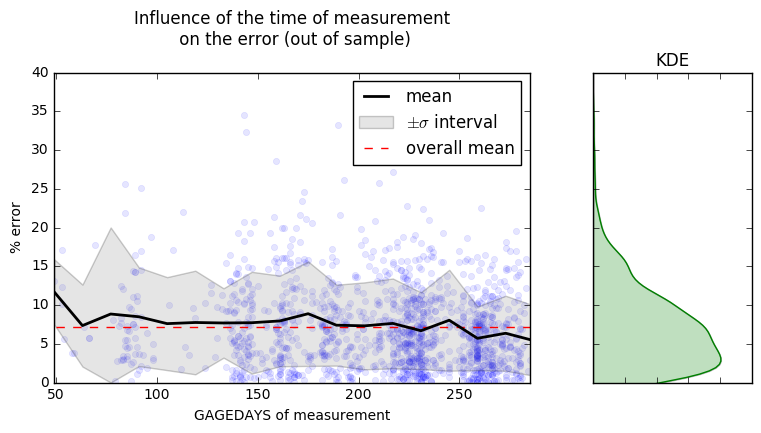

In [22]:
fig = plt.figure(figsize=(9,4))
gs = gridspec.GridSpec(1,2,width_ratios=[3,1])

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

sns.regplot(x=t,y=pct_error, scatter_kws={'alpha':0.1},fit_reg=False,ax=ax)
ax.plot(reescaled_x,pct_error_binned_df['mean'],label='mean',lw=2,color='k')
ax.fill_between(reescaled_x, pct_error_binned_df['lower'], pct_error_binned_df['upper'], 
                 facecolor='grey', alpha=0.2, label=r'$\pm \sigma$ interval')
ax.set_xlim(t.min(),t.max())
ax.set_ylim(0,40)
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.set_title('Influence of the time of measurement\n on the error (out of sample)\n')
ax.hlines(mean_pct_error,xmin=0,xmax=350,colors='r',linestyles='dashed',label='overall mean')
ax.legend()

sns.kdeplot(pct_error, vertical=True,legend=False, shade=True, lw=1, ax=ax2)
ax2.set_title('KDE')
ax2.set_ylabel('')
ax2.set_ylim(0,40)
ax2.set_xlim(0,0.1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.show();

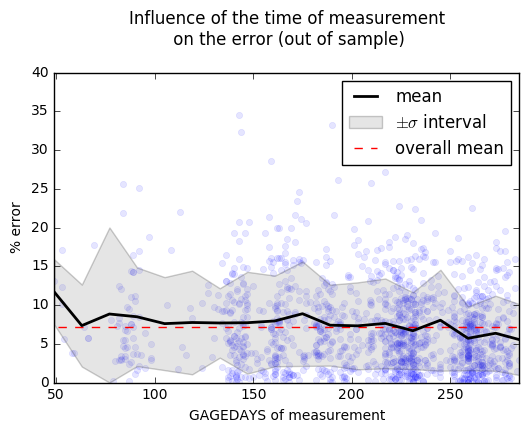

In [24]:
ax = sns.regplot(x=t,y=pct_error, scatter_kws={'alpha':0.1},fit_reg=False)
ax.plot(reescaled_x,pct_error_binned_df['mean'],label='mean',lw=2,color='k')
ax.fill_between(reescaled_x, pct_error_binned_df['lower'], pct_error_binned_df['upper'], 
                 facecolor='grey', alpha=0.2, label=r'$\pm \sigma$ interval')
ax.set_xlim(t.min(),t.max())
ax.set_ylim(0,40)
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.set_title('Influence of the time of measurement\n on the error (out of sample)\n')
ax.hlines(mean_pct_error,xmin=0,xmax=350,colors='r',linestyles='dashed',label='overall mean')
plt.legend();

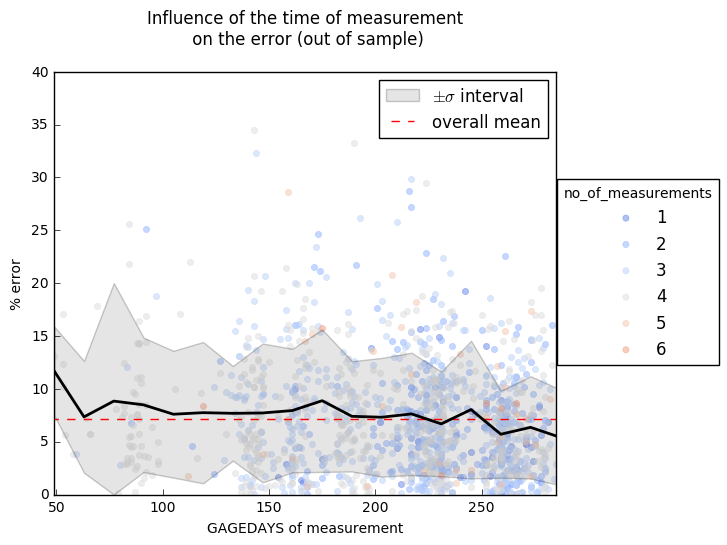

In [25]:
ax = sns.lmplot(x='t',y='pct_error', hue='no_of_measurements', data=data_plot, fit_reg=False,
          scatter_kws={'alpha':0.5}, palette=sns.color_palette("coolwarm", 7), aspect=1.2).ax
ax.plot(reescaled_x,pct_error_binned_df['mean'],label='mean',lw=2,color='k')
ax.fill_between(reescaled_x, pct_error_binned_df['lower'], pct_error_binned_df['upper'], 
                 facecolor='grey', alpha=0.2, label=r'$\pm \sigma$ interval')
ax.set_xlim(t.min(),t.max())
ax.set_ylim(0,40)
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.set_title('Influence of the time of measurement\n on the error (out of sample)\n')
ax.hlines(mean_pct_error,xmin=0,xmax=350,colors='r',linestyles='dashed',label='overall mean')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-2:],labels=labels[-2:])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True);

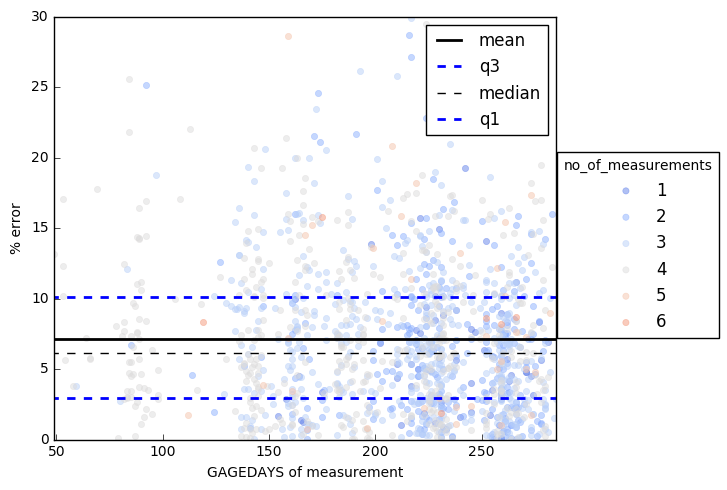

In [26]:
ax = sns.lmplot(x='t',y='pct_error', hue='no_of_measurements', data=data_plot, fit_reg=False,
          scatter_kws={'alpha':0.5}, palette=sns.color_palette("coolwarm", 7), aspect=1.2).ax
ax.set_ylim(0,30)
ax.set_xlim(t.min(),t.max())
ax.set_xlabel('GAGEDAYS of measurement')
ax.set_ylabel('% error')
ax.hlines(mean_pct_error,xmin=0,xmax=350,colors='k',label='mean', lw=2)
ax.hlines(data_plot['pct_error'].quantile(0.75),xmin=0,xmax=350,colors='b',linestyles='dashed',label='q3', lw=2)
ax.hlines(data_plot['pct_error'].quantile(0.5),xmin=0,xmax=350,colors='k',linestyles='dashed',label='median')
ax.hlines(data_plot['pct_error'].quantile(0.25),xmin=0,xmax=350,colors='b',linestyles='dashed',label='q1', lw=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-4:],labels=labels[-4:])
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True);

In [27]:
time.time() - start

49.21759080886841

In [28]:
print('Latest execution: %s' % pd.datetime.now())

Latest execution: 2016-11-29 12:29:43.915196
